# Отчёт к домашнему заданию №1

### Автор: Романов Алексей Денисович

Импорт всех необходимых библиотек:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install fasttext
import fasttext
from sklearn.metrics import f1_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from multiprocessing import Pool
from collections import Counter
from sklearn.manifold import TSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Часть 1

Первым шагом скачиваем данные. Данная ячейка копирует архив с токенизированными текстами в нижнем регистре в папку проекта с Google.Диск и разархивирует его. Для переиспользования необходимо заменить путь на свой.

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/NLP/hpac_lower_tokenized.zip" .
!unzip hpac_lower_tokenized.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: hpac_source/4615642     
  inflating: hpac_source/7028138     
  inflating: hpac_source/7525139     
  inflating: hpac_source/5172600     
  inflating: hpac_source/3857376     
  inflating: hpac_source/5349382     
  inflating: hpac_source/4716141     
  inflating: hpac_source/2527816     
  inflating: hpac_source/9002674     
  inflating: hpac_source/12377877    
  inflating: hpac_source/4482433     
  inflating: hpac_source/12561875    
  inflating: hpac_source/3958842     
  inflating: hpac_source/2744273     
  inflating: hpac_source/7534883     
  inflating: hpac_source/9342729     
  inflating: hpac_source/9827191     
  inflating: hpac_source/4085248     
  inflating: hpac_source/2801654     
  inflating: hpac_source/6761621     
  inflating: hpac_source/9744246     
  inflating: hpac_source/2422618     
  inflating: hpac_source/11162505    
  inflating: hpac_source/10956839    
  inflating: hpac_so

1. Найдите топ-1000 слов по частоте без учета стоп-слов.

Для более качественного поиска количеств вхождений слов определим простую функцию препроцессинга текстов. Она оставляет в тексте только слова/цифры, приводит слова к начальной форме простым лемматизатором для английского языка, удаляет стоп-слова.

In [ ]:
useless_words = stopwords.words('english') + [""]
regex = re.compile("[A-Za-z0-9]+")
wordnet_lemmatizer = WordNetLemmatizer()

def preproc_text(text, lemmatize = True):
    try:
        result = regex.findall(text.lower())
    except:
        result = []
    new_result = []
    for word in result:
        if lemmatize:
            lemma = wordnet_lemmatizer.lemmatize(word)
        else:
            lemma = word
        if lemma not in useless_words:
            new_result.append(lemma)
    return new_result

def preproc_file(file):
    with open("hpac_source//"+file) as f:
        text = f.read()
    cleaned_tokens = preproc_text(text)
    return cleaned_tokens

Пройдёмся по каждому тексту и посчитаем слова:

In [ ]:
files = os.listdir("hpac_source")

lemmas = {}
for i in tqdm(range(len(files))):
    lemmas = dict(Counter(lemmas) + Counter(preproc_file(files[i])))

С приведением слов к начальной форме считалось довольно долго (за пару часов обработалась чуть больше половины текстов). Однако без лемматизации результат получается немного другой и менее честный (так, одно и то же слово в разных формах считается за разные и, соответственно, его "популярность" занижается).

Как оказалось, в текстах очень много странных токенов (непонятные наборы букв и цифр). Отфильтруем такие из нашего счётчика слов и выведем топ слов по частоте.

In [ ]:
result = pd.DataFrame.from_dict(lemmas,orient="index").reset_index().set_axis(["word","num"],axis=1)
top_words = result[(~result["word"].apply(lambda x: x.isnumeric())) & (result["word"].str.len()>1)].sort_values(by="num",ascending=False).iloc[:1000]["word"].values
top_words

array(['harry', 'said', 'would', 'hermione', 'could', 'draco', 'back',
       'one', 'like', 'know', 'eye', 'time', 'looked', 'ron', 'get',
       'asked', 'well', 'even', 'around', 'head', 'see', 'think', 'going',
       'still', 'go', 'ginny', 'face', 'way', 'room', 'severus', 'hand',
       'something', 'want', 'snape', 'thought', 'potter', 'sirius',
       'right', 'away', 'much', 'two', 'look', 'never', 'knew', 'really',
       'first', 'made', 'let', 'good', 'little', 'malfoy', 'felt',
       'turned', 'wand', 'dumbledore', 'james', 'come', 'got', 'make',
       'remus', 'took', 'sure', 'looking', 'door', 'say', 'though',
       'tell', 'dark', 'take', 'lily', 'long', 'u', 'voice', 'last',
       'need', 'told', 'yes', 'man', 'voldemort', 'left', 'wanted',
       'anything', 'oh', 'next', 'came', 'nodded', 'love', 'saw',
       'moment', 'another', 'people', 'thing', 'year', 'hand', 'went',
       'smiled', 'day', 'ca', 'death', 'enough', 'help', 'boy',
       'professor', 'mind'

2. Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия.

Теперь высчитаем самые популярные имена, имена + фамилии, профессоров. Для этого в интернете был найден список всех героев книг о Гарри Поттере. Тогда для решения задачи остаётся лишь найти количество вхождений заданных комбинаций токенов.

Однако список имён и фамилий нужно предобработать перед использованием. Ниже происходит очистка имён и фамилий от лишних инициалов и символов, приведение их к нижнему регистру. Для поиска профессоров делается список уникальных имён и уникальных фамилий и к ним конкатенируется слово "professor".

In [ ]:
characters = pd.read_csv("harry-potter-characters.csv",usecols=["name"])
names = characters["name"].apply(lambda x: re.sub(r'[^A-z]', '', x.split(" ")[0].lower())).unique()
names_surnames = characters["name"].apply(lambda x:" ".join([re.sub(r'[^A-z]', '', word.lower()) for word in x.split(" ")])).unique()
professors = np.unique(["professor "+re.sub(r'[^A-z]', '', word.lower()) for subset in characters["name"].str.split(" ").values for word in subset])

Для решения будем искать вхождения  средствами регулярных выражений. В каждом тексте производится поиск подстрок, удовлетворяющих заданному регулярному выражению. Регулярное выражение представляет собой скобочную группу, которая должна содержать одно из имён/пары имя+фамилия или пары professor + имя/фамилия. Тогда подходящие под это регулярное выражение подстроки это подстроки, содержащие одно из заданных ранее словосочетаний.

In [ ]:
data_to_search = pd.concat([
    pd.DataFrame({"words":list(names) + ["voldemort"], "type":["names"]*(names.shape[0]+1)}),
    pd.DataFrame({"words":names_surnames, "type":["names_surnames"]*names_surnames.shape[0]}),
    pd.DataFrame({"words":professors, "type":["professors"]*professors.shape[0]})
])
data_to_search = data_to_search[data_to_search["words"].apply(lambda x: len(set(x.split()).intersection(set(stopwords.words('english')+["lord","great"]))))==0]
regex = re.compile("("+("|".join((data_to_search["words"]).values))+")")

Проверим работоспособность на 5 текстах:

In [ ]:
files = os.listdir("hpac_source")

lemmas={}
for i in tqdm(range(5)):
    with open("hpac_source//"+files[i]) as f:
        text = f.read()
    lemmas = dict(Counter(lemmas) + Counter(regex.findall(text.lower())))

100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


In [ ]:
lemmas

{'voldemort': 22,
 'ted': 316,
 'narcissa': 4,
 'lucius': 10,
 'draco': 467,
 'cho': 38,
 'ron': 41,
 'mary': 3,
 'harry': 733,
 'professor burbage': 4,
 'charity': 1,
 'severus': 3,
 'nagini': 2,
 'fang': 2,
 'marcus': 1,
 'mrs': 8,
 'stan': 49,
 'lee': 32,
 'hermione': 38,
 'rose': 11,
 'nearly': 6,
 'viktor': 9,
 'colin': 3,
 'teddy': 71,
 'sirius': 24,
 'remus': 11,
 'neville': 14,
 'james': 2,
 'sir': 7,
 'gilderoy': 1,
 'theodore': 2,
 'bill': 1,
 'lavender': 7,
 'parvati': 6,
 'padma': 6,
 'fleur': 29,
 'gabrielle': 7,
 'albus': 2,
 'rita': 2,
 'ginny': 10,
 'oliver': 7,
 'pansy': 11,
 'barty': 6,
 'blaise': 20,
 'lily': 1}

Теперь выполним подсчёт для всех наших текстов.

In [ ]:
files = os.listdir("hpac_source")

lemmas={}
for i in tqdm(range(len(files))):
    with open("hpac_source//"+files[i]) as f:
        text = f.read()
    lemmas = dict(Counter(lemmas) + Counter(regex.findall(text.lower())))

 81%|████████▏ | 29445/36225 [2:05:45<28:57,  3.90it/s]


KeyboardInterrupt: ignored

In [ ]:
result = pd.DataFrame.from_dict(lemmas,orient="index").reset_index().set_axis(["word","num"],axis=1)

Топ 10 имён:

In [ ]:
word_type="names"
pd.merge(
    data_to_search[data_to_search["type"]==word_type].rename(columns={"words":"word"}),
    result,
    on="word",
    how="inner"
).sort_values(by="num",ascending=False)["word"].iloc[:10].values

array(['harry', 'ted', 'hermione', 'ron', 'draco', 'ginny', 'severus',
       'stan', 'sirius', 'cho'], dtype=object)

Топ 10 профессоров:

In [ ]:
word_type="professors"
pd.merge(
    data_to_search[data_to_search["type"]==word_type].rename(columns={"words":"word"}),
    result,
    on="word",
    how="inner"
).sort_values(by="num",ascending=False)["word"].iloc[:10].values

array(['professor snape', 'professor mcgonagall', 'professor dumbledore',
       'professor lupin', 'professor flitwick', 'professor slughorn',
       'professor sprout', 'professor trelawney', 'professor umbridge',
       'professor longbottom'], dtype=object)

# Часть 2

Для начала представим все тексты в читаемом для fasttext виде (сохраним все предложения в один файл, разделяя их символом новой строки):

In [ ]:
with open('all_texts_hpac.train', 'w') as f:
    files = os.listdir("hpac_source")
    for i in tqdm(range(len(files))):
        with open("hpac_source//"+files[i]) as g:
            text = g.read()
        f.write(text)
        f.write("\n")

100%|██████████| 36225/36225 [00:24<00:00, 1479.81it/s]


Обучение модели и её сохранение:

In [ ]:
model = fasttext.train_unsupervised('all_texts_hpac.train', "skipgram", dim = 50, thread=12, epoch = 3)
model.save_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//all_texts_hpac_fasttext.bin")

Проверим как хорошо модель выучила взаимосвязи между словами:

1.Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

Для начала проверим работу поиска похожих слов:

1. Похожие слова на слово voldemort (для лучшего понимания качества работы модели из выдачи удалены слова voldemort с опечатками, которых было большинство среди ближайших векторов, что тоже неплохо, но нам интересна ещё и близость с другими словами):

In [ ]:
similars = model.get_nearest_neighbors('voldemort',100)
count = 0
for similar in similars:
    if count>=10:
        break
    if "vold" not in similar[1]:
        count+=1
        print(similar)

(0.8686057329177856, 'lord')
(0.8638769388198853, 'valdemort')
(0.8273025751113892, 'he-who-must')
(0.8177664279937744, 'grindelwald')
(0.817740797996521, 'gellert')
(0.81370609998703, 'vodemort')
(0.807615339756012, 'deatheather')
(0.8048369288444519, 'demort')
(0.8034046292304993, 'deatheater')
(0.801332414150238, 'he-who-must-not-be')


Довольно неплохо, ведь у нас здесь собрались и другие отрицательные герои (deatheather, grindelwald), и опечатки слова voldemort, и его прозвища (he-who-must-not-be ...).

2. Для слова harry самые близкие вектора - вектора его друзей и школьного врага.

In [ ]:
model.get_nearest_neighbors('harry',5)

[(0.8903449177742004, 'hermione'),
 (0.8820620775222778, '.'),
 (0.8670722246170044, 'he'),
 (0.8656813502311707, 'ron'),
 (0.8599306344985962, 'draco')]

3. Проверяем что ближайшее к слову "privet" (по предположению должно быть drive, где жил Гарри Поттер).

In [ ]:
model.get_nearest_neighbors('privet',1)

[(0.8567904829978943, 'drive')]

4. К слову avada ближайшие разные написания этого заклинания (опечатки) и другие непростительные заклинания (cruicio).

In [ ]:
model.get_nearest_neighbors('avada',25)

[(0.959877610206604, 'kedavra'),
 (0.9570379257202148, 'kedav'),
 (0.9559561014175415, 'avada_kedavra'),
 (0.9484478831291199, 'avada_kedavras'),
 (0.9458463788032532, 'kadavra'),
 (0.9449848532676697, 'kedava'),
 (0.943509042263031, 'kedvra'),
 (0.933820366859436, 'kedavera'),
 (0.9334129691123962, 'kedavara'),
 (0.9255278706550598, 'keda'),
 (0.9252216815948486, 'adavra'),
 (0.9220765233039856, 'kedarva'),
 (0.917157769203186, 'avad'),
 (0.9128288626670837, 'kedarava'),
 (0.9104545712471008, 'avadra'),
 (0.9065098166465759, 'kedevra'),
 (0.8847200274467468, 'kedrava'),
 (0.8841072916984558, 'kadavera'),
 (0.8744922280311584, 'avada-ed'),
 (0.8719797134399414, 'kadava'),
 (0.8714974522590637, 'kedvara'),
 (0.8710869550704956, 'crucio'),
 (0.8663289546966553, 'aveda'),
 (0.8641036152839661, 'kedabra'),
 (0.8595463633537292, 'cruicio')]

В результате можем сказать, что поиск похожих слов работает довольно неплохо, так как во всех тестах модель выдаёт здравые результаты (даже не пришлось выискивать пригодные примеры).

Теперь проверим поиск ассоциаций:

1. Смысл ассоциации: lily - жена james, предполагается вывести жену для arthur (правильный ответ - molly)

In [ ]:
model.get_analogies("lily", "james", "arthur")

[(0.8888817429542542, 'molly'),
 (0.8459604978561401, 'arthurs'),
 (0.824330747127533, 'grandys'),
 (0.815710186958313, 'grangie'),
 (0.8134638667106628, 'mrs.weasley'),
 (0.8110072016716003, 'mrs.'),
 (0.7964476346969604, 'angie'),
 (0.7953779101371765, 'bill'),
 (0.7906737327575684, 'mrs'),
 (0.7858814001083374, 'mollys')]

2. Смысл ассоциации: pigwidgeon - сова у ron, предполагается вывести сову для harry (правильный ответ - hedwig)

In [ ]:
model.get_analogies("pigwidgeon", "ron", "harry")

[(0.8599695563316345, 'hedwig'),
 (0.839804470539093, 'hedwigs'),
 (0.8169521689414978, 'pigwideon'),
 (0.814536452293396, 'owl'),
 (0.8129394054412842, 'hooter'),
 (0.7940885424613953, 'bird'),
 (0.7847358584403992, 'hooted'),
 (0.7654615044593811, 'hoot'),
 (0.7622032761573792, 'flapper'),
 (0.7549806833267212, 'messenger')]

3. Смысл ассоциации: padfoot - прозвище sirius-а, предполагается вывести прозвище для remus (правильный ответ - moony).

In [ ]:
model.get_analogies("padfoot", "sirius", "remus")

[(0.942560613155365, 'moony'),
 (0.9159247875213623, 'prongs'),
 (0.9106904864311218, 'padfoots'),
 (0.8983641266822815, 'prongsy'),
 (0.8949417471885681, 'mooney'),
 (0.8768422603607178, 'prongsh'),
 (0.8697264790534973, 'padfood'),
 (0.8583176732063293, 'dadfoot'),
 (0.8581278920173645, 'padf'),
 (0.8480374217033386, 'prongsie')]

Ассоциации также работают очень не плохо.

2. Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP

In [ ]:
embeds = []
for word in top_words:
    embeds.append(model[word])
embeds=np.array(embeds)

In [ ]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeds)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


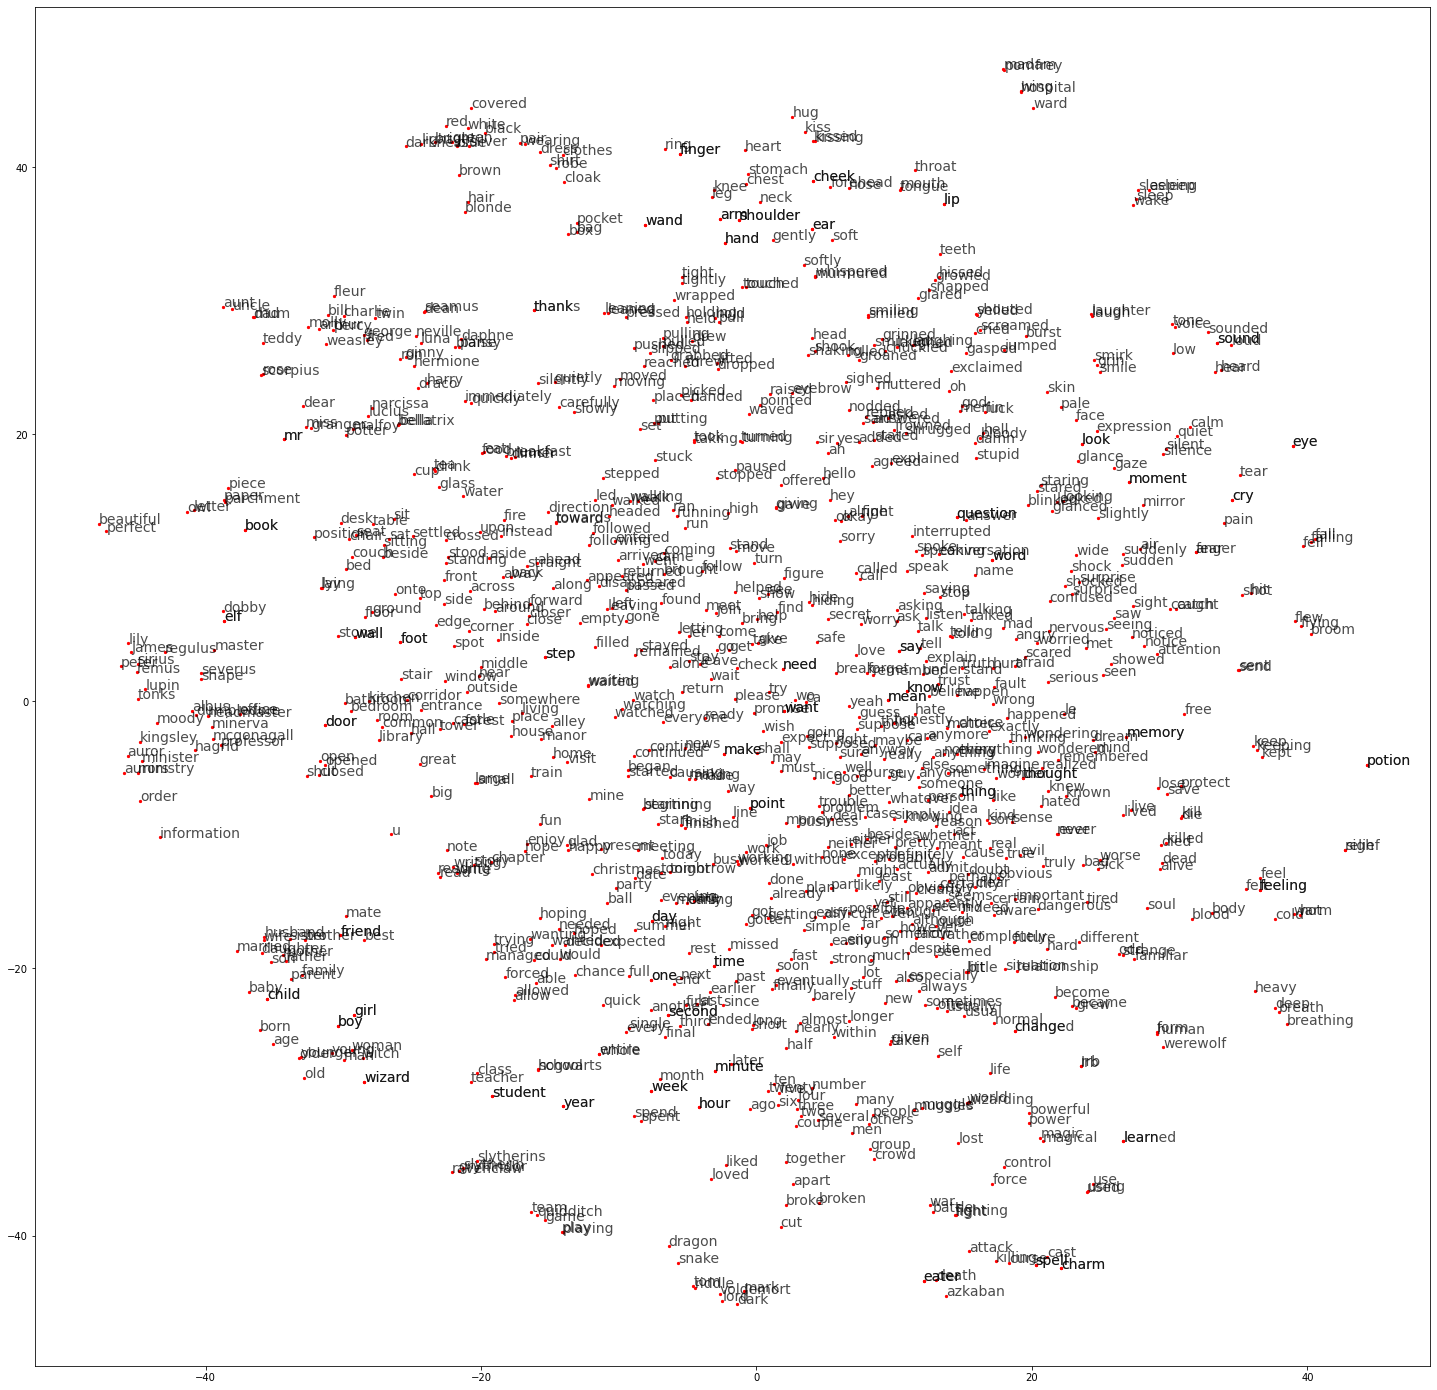

In [ ]:
plt.figure(figsize=(25, 25))
for idx in range(len(top_words)):
    plt.scatter(*embed_tsne[idx, :], color="r",s=5)
    plt.annotate(top_words[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,fontsize=14)

Получилось также довольно неплохо. Среди сгустков нередко расположены действительно похожие слова, например:

a) dobby, elf

b) quidditch, team, play ...

c) slutherins, ravenclaw ...

d) snake, voldemort, dark

e) azkaban, deatheater

f) student, teacher, class

...

# Часть 3

Теперь решим задачу классификации, а именно будем предсказывать, какое именно заклинание будет произнесено по тексту, описывающему ситуацию.

Скачиваем данные. Данная ячейка копирует архив с текстами для классификации и разархивирует его. Для переиспользования необходимо заменить путь на свой.

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/NLP/hpac_splits.zip" .
!unzip hpac_splits.zip

Archive:  hpac_splits.zip
   creating: hpac_corpus/
  inflating: hpac_corpus/hpac_training_128.tsv  
   creating: __MACOSX/
   creating: __MACOSX/hpac_corpus/
  inflating: __MACOSX/hpac_corpus/._hpac_training_128.tsv  
  inflating: hpac_corpus/hpac_dev_128.tsv  
  inflating: __MACOSX/hpac_corpus/._hpac_dev_128.tsv  
  inflating: hpac_corpus/hpac_test_128.tsv  
  inflating: __MACOSX/hpac_corpus/._hpac_test_128.tsv  
  inflating: __MACOSX/._hpac_corpus  


Читаем данные для обучения, валидации и тестирования готовых моделей:

In [ ]:
train=pd.read_csv('hpac_corpus//hpac_training_128.tsv', sep='\t', names=["tmp","target","text"])
val=pd.read_csv('hpac_corpus//hpac_dev_128.tsv', sep='\t', names=["tmp","target","text"])
test=pd.read_csv('hpac_corpus//hpac_test_128.tsv', sep='\t', names=["tmp","target","text"])

Для дальнейшей проверки построенных моделей на адекватность построим самый простой классификатор, выдающий всегда один ответ - самый часто встречающийся класс:

In [ ]:
base_pred = train["target"].value_counts().index[0]
print(f"Самый часто встречающийся класс: {base_pred}")

Самый часто встречающийся класс: AVADA_KEDAVRA


Теперь посчитаем целевую мерику этого классификатора:

In [ ]:
score = f1_score(test["target"],np.array([base_pred]*test.shape[0]),average="macro")
print(f"F1 (macro avg.) = {score}")

F1 (macro avg.) = 0.0025349911898666843


Видим, что качество этого базового классификатора равно качеству, приведённому в статье, то есть делаем предположение, что качество и сложность текстов не сильно поменялось с тех времён. Поэтому будем сравнивать качества наших моделей с приведёнными в статье и будем пытаться их побить.

1. Используйте fastText в качестве baseline-классификатора.

fastText из коробки может обучаться на задачу классификации. Используем это и обучим классификатор. Перед этим сформируем файл с данными для модели fastText в читаемом для неё формате (записываем всё в один файл с форматом строки "__ label __{метка класса} {текст}".

In [ ]:
ft_train = pd.concat([train,val])
ft_train["data"] = "__label__" + ft_train["target"] + " " + ft_train["text"]
with open('hpac.train', 'w') as f:
    f.write("\n".join(ft_train["data"].values))

Обучим для начала с базовыми гиперпараметрами и сохраним модель:

In [ ]:
model = fasttext.train_supervised(input="hpac.train")
model.save_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin")

Произведём подсчёт качества построенной модели (будем считать целевую метрику, то есть F1 (macro avg.)):

In [ ]:
ft_test_pred = np.array(model.predict(list(test["text"].values))[0]).reshape(-1)
ft_test_pred = np.array([s.replace("__label__","") for s in ft_test_pred])

In [ ]:
score = f1_score(test["target"],ft_test_pred,average="macro")
print(f"F1 (macro avg.) = {score}")

F1 (macro avg.) = 0.021693454230444626


Качество этого классификатора заметно лучше, чем у классификатора, выдающео самый частый класс. Следовательно, действительно можем использовать его как baseline. Всё равно качество не очень хорошее, поэтому попробуем также увеличить количество эпох, так как по умолчанию их мало. Не трогаем остальные параметры, так как практика показала, что если это делать автоматически с помощью функционала fasttext, передав ему валидационный датасет, то модель сильно переобучается под него, имея низкое качество на тесте.

In [ ]:
model = fasttext.train_supervised(input="hpac.train", epoch=20, loss='hs')
model.save_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin")

In [ ]:
ft_test_pred = np.array(model.predict(list(test["text"].values))[0]).reshape(-1)
ft_test_pred = np.array([s.replace("__label__","") for s in ft_test_pred])

In [ ]:
score = f1_score(test["target"],ft_test_pred,average="macro")
print(f"F1 (macro avg.) = {score}")

F1 (macro avg.) = 0.06396984495921618


Действительно улучшение есть. Судя по приведённым в статье результатам baseline получился неплохой, так как качество сравнимо с некоторыми использованными авторами моделями.

2. Используйте сверточные или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать  k -max pooling.

В данной задаче были выбраны реккурентные нейронные сети, так как, судя по статье, они показали себя лучше других использованных моделей. Так как тексты довольно длинные (максимум 128 токенов), то будем использовать вариацию LSTM, так как они менее всех предрасположены к забыванию. При использовании LSTM будем следовать совету из статьи: на вход рекуррентной сетке будем подавать последовательно эмбеддинги токенов текста, причём эмбеддинг будет формироваться путём конкатенирования полученного ранее эмбеддинга из fasttext и своего обучаемового эмбеддинга (практика показала, что так модель обучается сильно быстрее).

Для удобства сделаем список слов, в который добавим слово "\<pad\>", словари для перевода слов в индексы, классов в индексы и наоборот (далее будет описано зачем это более подробно):

In [ ]:
words = np.array(pd.concat([train["text"],val["text"],test["text"]]).apply(lambda x: x.split(" ")).values)
words = sorted(list(set([word for subtext in words for word in subtext])))
words = words + ["<pad>",]
print(f"Количество уникальных токенов в корпусе: {len(words)}")

Количество уникальных токенов в корпусе: 63640


In [ ]:
int2word = dict(enumerate(words))
word2int = {word: num for num, word in int2word.items()}

int2class = dict(enumerate(np.sort(train["target"].unique())))
class2int = {word: num for num, word in int2class.items()}

Это действие было сделано для того, чтобы реализовать удобное итерирование по батчам в дальнейшем. Теперь опишу мой вариант формирования батчей. Пусть батч - набор из $N$ текстов. Каждый i-й текст делится на токены, после чего каждый j-й токен в каждом i-м тексте кодируется своим индексом в словаре. Тогда получаем, что i-й текст превращается в массив индексов входящих в него слов. Для того чтобы батч имел постоянную размерность, более которкие тексты в батче дозаполняются индексами токена \<pad\>.

Теперь сделаем класс датасета, который это реализует.

In [ ]:
class HPDataset(Dataset):
    def __init__(self, data, word2int, class2int):
        self.pad_index=word2int["<pad>"]
        self.texts = np.array(list(data["text"].apply(lambda x: [word2int[token] for token in x.split(" ")] + [self.pad_index]*(128-len(x.split(" "))))))
        self.targets=data["target"].apply(lambda x: class2int[x]).values

    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, index):
        return self.texts[index], self.targets[index]

Теперь реализуем класс модели. При forward pass модель принимает батч текстов в форме, описанной выше (то есть текст - список индексов входящих в него токенов). По переданным в батче индексам токенов восстанавливается их эмбеддинги из переданной fasttext_model и затем конкатенируются уже с обучаемым эмбеддингом. То есть эта конкатенация и есть полный эмбеддинг токена. Далее эти эмбеддинги токенов текста подаются последовательно в LSTM сеть (которую можно сделать многослойной и двунаправленной, настроить нужный dropout между её слоями). Выход с последнего слоя LSTM уже подаётся в линейный слой, который выдаёт вектор размерности равной количеству классов.

In [ ]:
class MyLSTM(nn.Module):
    def __init__(
                 self,
                 vocab_size,
                 n_classes,
                 addition_embed_size=128,
                 fasttext_model=None,
                 int2word=None,
                 hidden_size=256,
                 n_layers=2,
                 dropout=0.5,
                 bidirectional=False
        ):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.addition_embed_size = addition_embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.fasttext_model = fasttext_model
        if self.fasttext_model is None:
            self.fasttext_embed_size = 0
        else:
            self.fast_text_embeds=torch.tensor([self.fasttext_model.get_word_vector(word) for word in int2word.values()])
            self.fasttext_embed_size = self.fast_text_embeds.shape[1]
        
        self.embedding = nn.Embedding(self.vocab_size, self.addition_embed_size)
        self.lstm = nn.LSTM(
            self.addition_embed_size + self.fasttext_embed_size,
            self.hidden_size,
            self.n_layers,
            dropout=self.dropout,
            bidirectional=self.bidirectional,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size + self.bidirectional*self.hidden_size, self.n_classes)
    
    def forward(self, x, device = "cpu"):
        embeds = self.embedding(x)
        if self.fasttext_model is not None:
            fast_text_embeds = self.fast_text_embeds[x.reshape(-1)].reshape(x.shape[0],x.shape[1],-1)
            embeds = torch.cat([embeds, fast_text_embeds.to(device)],dim=2)
        
        output, hidden = self.lstm(embeds)
        output = output[:,-1,:].contiguous()
        out = self.fc(output)
        return out


Ниже представлена функция, реализующая обучение сети. Она довольно стандартная: оптимизатор Adam, лосс - CrossEntropyLoss, можно задать количество эпох, размер батча, learning_rate. Раз в print_every шагов выводится целевая метрика и лосс на валидационном датасете и если качество выросло, модель пересохраняется на диске. Кроме того, здесь добавлено обрезацие взрывающихся градиентов по норме (параметр clip).

In [ ]:
def training(net, train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, clip=5, print_every=10, save_file="//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm.pth"):
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
    net = net.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    counter = 0
    prev_metrics = 0
    for e in range(epochs):
        for batch_texts, batch_targets in train_loader:
            net.train()
            counter += 1

            inputs, targets = batch_texts.to(device), batch_targets.to(device)

            net.zero_grad()
            output = net(inputs, device)

            loss = criterion(output, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            if counter % print_every == 0:
                val_losses = []
                net.eval()
                val_predictions = np.array([])
                val_targets = np.array([])
                for batch_texts, batch_targets in val_loader:
                    inputs, targets = batch_texts.to(device), batch_targets.to(device)

                    output = net(inputs, device)
                    val_loss = criterion(output, targets)
                
                    val_losses.append(val_loss.item())

                    val_targets = np.append(val_targets, batch_targets.detach().numpy().reshape(-1))
                    val_predictions = np.append(val_predictions, output.cpu().detach().numpy().argmax(axis=1))
                
                net.train()
                
                metrics = f1_score(val_targets,val_predictions,average="macro")
                print("Epoch: {}/{}   ".format(e+1, epochs),
                      "Step: {}   ".format(counter),
                      "Loss: {:.4f}   ".format(loss.item()),
                      "Val Loss: {:.4f}   ".format(np.mean(val_losses)),
                      "Val F1 macro: {:.4f}   ".format(metrics))
                if metrics >= prev_metrics:
                    torch.save(net.state_dict(), save_file)
                    prev_metrics = metrics
                

Вспомогательные функции для оценивания итоговой модели:

In [ ]:
def evaluation(net, test_dataset):
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()

    val_loader = DataLoader(test_dataset, batch_size=128)
    val_losses = []
    net.eval()
    val_predictions = np.array([])
    val_targets = np.array([])
    for batch_texts, batch_targets in val_loader:
        inputs, targets = batch_texts.to(device), batch_targets.to(device)

        output = net(inputs, device)
        val_loss = criterion(output, targets)
                
        val_losses.append(val_loss.item())

        val_targets = np.append(val_targets, batch_targets.detach().numpy().reshape(-1))
        val_predictions = np.append(val_predictions, output.cpu().detach().numpy().argmax(axis=1))
                
    net.train()
                
    metrics = f1_score(val_targets,val_predictions,average="macro")
    print("Test Loss: {:.4f}   ".format(np.mean(val_losses)),
          "Test F1 macro: {:.4f}   ".format(metrics))

def prediction(net, test_dataset):
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
    net = net.to(device)

    val_loader = DataLoader(test_dataset, batch_size=128)
    net.eval()
    val_predictions = np.array([])
    val_targets = np.array([])
    for batch_texts, batch_targets in val_loader:
        inputs, targets = batch_texts.to(device), batch_targets.to(device)
        output = net(inputs, device)     
        val_targets = np.append(val_targets, batch_targets.detach().numpy().reshape(-1))
        val_predictions = np.append(val_predictions, output.cpu().detach().numpy().argmax(axis=1))
                
    net.train()
                
    return val_targets, val_predictions

Обучаем модель:

In [ ]:
train_dataset = HPDataset(train, word2int, class2int)
val_dataset = HPDataset(val, word2int, class2int)
test_dataset = HPDataset(test, word2int, class2int)

net = MyLSTM(
    vocab_size=len(int2word),
    n_classes=len(int2class),
    addition_embed_size=256,
    fasttext_model=fasttext.load_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin"),
    int2word=int2word,
    hidden_size=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [ ]:
training(net, train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, clip=5, print_every=10, save_file="//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm.pth")

Epoch: 1/10    Step: 10    Loss: 3.6383    Val Loss: 3.5626    Val F1 macro: 0.0050   
Epoch: 1/10    Step: 20    Loss: 3.4099    Val Loss: 3.4953    Val F1 macro: 0.0065   
Epoch: 1/10    Step: 30    Loss: 3.7245    Val Loss: 3.4663    Val F1 macro: 0.0053   
Epoch: 1/10    Step: 40    Loss: 3.3821    Val Loss: 3.4372    Val F1 macro: 0.0069   
Epoch: 1/10    Step: 50    Loss: 3.7229    Val Loss: 3.4241    Val F1 macro: 0.0106   
Epoch: 1/10    Step: 60    Loss: 3.7286    Val Loss: 3.4258    Val F1 macro: 0.0101   
Epoch: 1/10    Step: 70    Loss: 3.2163    Val Loss: 3.3726    Val F1 macro: 0.0123   
Epoch: 1/10    Step: 80    Loss: 3.2470    Val Loss: 3.3212    Val F1 macro: 0.0186   
Epoch: 1/10    Step: 90    Loss: 3.3765    Val Loss: 3.2701    Val F1 macro: 0.0154   
Epoch: 1/10    Step: 100    Loss: 3.3686    Val Loss: 3.3114    Val F1 macro: 0.0123   
Epoch: 1/10    Step: 110    Loss: 3.1602    Val Loss: 3.2707    Val F1 macro: 0.0176   
Epoch: 1/10    Step: 120    Loss: 3.1711 

KeyboardInterrupt: ignored

По динамике функции потерь и целевой метрики на валидационном датасете видно, что рост качества остановился. Стоит уменьшить learning rate и продолжить обучение, но сначала высчитаем качество на тестовом наборе данных:

In [ ]:
with open('//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm.pth', 'rb') as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

In [ ]:
evaluation(net, test_dataset)

Test Loss: 2.6415    Test F1 macro: 0.1475   


Видим, что качество получилось неплохое по сравнению с baseline моделью. Кроме того, судя по статье, качество получилось даже лучше всех моделей, которые пробовали авторы.

В задании сказано поисследовать влияние некоторых гиперпараметров на модель CNN. Я выбрал RNN, поэтому попробуем менять гиперпараметры, которые соответсвуют им (а именно, выбранному варианту LSTM).

Проверим, можно ли улучшить результат с другими гиперпараметрами. Интуитивно кажется, что модель недостаточно сложная, так как мы имеем, что улучшение качества остановилось, а сильного переобучения не наблюдалось. 

In [ ]:
net = MyLSTM(
    vocab_size=len(int2word),
    n_classes=len(int2class),
    addition_embed_size=512,
    fasttext_model=fasttext.load_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin"),
    int2word=int2word,
    hidden_size=512,
    n_layers=3,
    dropout=0.5,
    bidirectional=True
)

In [ ]:
training(net, train_dataset, val_dataset, epochs=10, batch_size=128, lr=0.001, clip=5, print_every=10, save_file="//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm_big.pth")

Epoch: 1/10    Step: 10    Loss: 3.3884    Val Loss: 3.5379    Val F1 macro: 0.0041   
Epoch: 1/10    Step: 20    Loss: 3.4944    Val Loss: 3.4781    Val F1 macro: 0.0057   
Epoch: 1/10    Step: 30    Loss: 3.5108    Val Loss: 3.4865    Val F1 macro: 0.0063   
Epoch: 1/10    Step: 40    Loss: 3.2879    Val Loss: 3.4230    Val F1 macro: 0.0070   
Epoch: 1/10    Step: 50    Loss: 3.4048    Val Loss: 3.4162    Val F1 macro: 0.0098   
Epoch: 1/10    Step: 60    Loss: 3.1530    Val Loss: 3.3726    Val F1 macro: 0.0147   
Epoch: 1/10    Step: 70    Loss: 3.3300    Val Loss: 3.4424    Val F1 macro: 0.0093   
Epoch: 1/10    Step: 80    Loss: 3.3027    Val Loss: 3.3516    Val F1 macro: 0.0156   
Epoch: 1/10    Step: 90    Loss: 3.3360    Val Loss: 3.2911    Val F1 macro: 0.0204   
Epoch: 1/10    Step: 100    Loss: 3.1206    Val Loss: 3.2453    Val F1 macro: 0.0191   
Epoch: 1/10    Step: 110    Loss: 3.1926    Val Loss: 3.2359    Val F1 macro: 0.0238   
Epoch: 1/10    Step: 120    Loss: 3.1287 

Улучшений не наблюдается. Возможно слишком сильно усложнили модель, так как начали заметно переобучаться. Произведём повторное обучение, упростив модель.

In [ ]:
net = MyLSTM(
    vocab_size=len(int2word),
    n_classes=len(int2class),
    addition_embed_size=128,
    fasttext_model=fasttext.load_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin"),
    int2word=int2word,
    hidden_size=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True
)

training(net, train_dataset, val_dataset, epochs=10, batch_size=128, lr=0.001, clip=5, print_every=10, save_file="//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm_small.pth")

Epoch: 1/10    Step: 10    Loss: 3.3695    Val Loss: 3.5676    Val F1 macro: 0.0026   
Epoch: 1/10    Step: 20    Loss: 3.5521    Val Loss: 3.4912    Val F1 macro: 0.0053   
Epoch: 1/10    Step: 30    Loss: 3.5381    Val Loss: 3.4638    Val F1 macro: 0.0042   
Epoch: 1/10    Step: 40    Loss: 3.3277    Val Loss: 3.4259    Val F1 macro: 0.0097   
Epoch: 1/10    Step: 50    Loss: 3.3881    Val Loss: 3.4083    Val F1 macro: 0.0069   
Epoch: 1/10    Step: 60    Loss: 3.1114    Val Loss: 3.3400    Val F1 macro: 0.0115   
Epoch: 1/10    Step: 70    Loss: 3.3752    Val Loss: 3.3916    Val F1 macro: 0.0136   
Epoch: 1/10    Step: 80    Loss: 3.4052    Val Loss: 3.3835    Val F1 macro: 0.0139   
Epoch: 1/10    Step: 90    Loss: 3.3268    Val Loss: 3.3176    Val F1 macro: 0.0182   
Epoch: 1/10    Step: 100    Loss: 3.2094    Val Loss: 3.2850    Val F1 macro: 0.0168   
Epoch: 1/10    Step: 110    Loss: 3.2037    Val Loss: 3.2157    Val F1 macro: 0.0197   
Epoch: 1/10    Step: 120    Loss: 3.1412 

In [ ]:
with open('//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm_small.pth', 'rb') as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

In [ ]:
evaluation(net, test_dataset)

Test Loss: 2.9519    Test F1 macro: 0.1397   


Стало хуже. Из этого делаем вывод, что усложнение и упрощение модели не даёт улучшение качества.

3. Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

Для расширения набора данных для обучения попробуем аугментировать исходные тексты. Для этого напишем функцию, которая для данного текста с вероятностью $p$ заменяет каждый токен в тексте на его синоним. Таким образом будем умножать количество текстов в $ratio\_to\_add$ раз для каждого выбранного класса. Исходя из выводов статьи будем расширять наборы для обучения только для редких в исходной выборке классов.

Список редких классов (менее 1% в выборке):

In [ ]:
small_classes = list(train["target"].value_counts()[(train["target"].value_counts()/train.shape[0])<0.01].index)
small_classes

['INCARCEROUS',
 'DIFFINDO',
 'IMPEDIMENTA',
 'LEVICORPUS',
 'EVANESCO',
 'SONORUS',
 'POINT_ME',
 'EPISKEY',
 'ENGORGIO',
 'CONFRINGO',
 'COLLOPORTUS',
 'PORTUS',
 'TERGEO',
 'RENNERVATE',
 'MORSMORDRE',
 'HOMENUM_REVELIO',
 'MOBILICORPUS',
 'EXPULSO',
 'LOCOMOTOR',
 'RELASHIO',
 'RICTUSEMPRA',
 'AVIS',
 'IMPERVIUS',
 'OPPUGNO',
 'FURNUNCULUS',
 'TARANTALLEGRA',
 'LOCOMOTOR_MORTIS',
 'SERPENSORTIA',
 'CONFUNDO',
 'QUIETUS',
 'REDUCIO',
 'LANGLOCK',
 'GEMINIO',
 'FERULA',
 'ORCHIDEOUS',
 'DENSAUGEO',
 'ANAPNEO',
 'APARECIUM',
 'DELETRIUS',
 'OBSCURO',
 'LIBERACORPUS',
 'DEPRIMO',
 'PRIOR_INCANTATO',
 'FLAGRATE',
 'WADDIWASI',
 'SPECIALIS_REVELIO',
 'PROTEGO_TOTALUM',
 'DURO',
 'SALVIO_HEXIA',
 'DEFODIO',
 'PIERTOTUM_LOCOMOTOR',
 'MOBILIARBUS',
 'GLISSEO',
 'ERECTO',
 'REPELLO_MUGGLETUM',
 'DESCENDO',
 'CAVE_INIMICUM',
 'PROTEGO_HORRIBILIS',
 'METEOLOJINX_RECANTO',
 'PESKIPIKSI_PESTERNOMI']

Описанная выше функция:

In [ ]:
def augmentate_dataset(train, p = 0.2, ratio_to_add = 3, chosen_classes=[]):
    np.random.seed(0)
    def augmentate_text(text):
        tokens=text.split(" ")
        new_text=[]
        for token in tokens:
            synsets_list=wn.synsets(token)
            if len(synsets_list)>0 and np.random.uniform()<p:
                lemmas=synsets_list[np.random.choice(len(synsets_list))].lemmas()
                new_token=lemmas[np.random.choice(len(lemmas))].name()
            else:
                new_token=token
            new_text.append(new_token)
        return " ".join(new_text)
    
    new_train=train.copy()
    data=train[train["target"].isin(chosen_classes)]
    for i in range(ratio_to_add):
        new_data=pd.DataFrame({"tmp":data["tmp"],"text":data["text"].apply(augmentate_text),"target":data["target"]})
        new_train=pd.concat([new_train,new_data])
    return new_train

Делаем новый тренировочный датасет с помощью описанной выше функции, то есть аугментируем тексты редких классов.

In [ ]:
new_train = augmentate_dataset(train, p = 0.2, ratio_to_add = 3, chosen_classes = small_classes)

Аналогично ранее описанным шагам делаем словари перевода всех токенов в индексы и словарь перевода классов в их индексы и наоборот (нужно их обновление, так как число уникальных токенов увеличелось после аугментаций).

In [ ]:
words = np.array(pd.concat([new_train["text"],val["text"],test["text"]]).apply(lambda x: x.split(" ")).values)
words = sorted(list(set([word for subtext in words for word in subtext])))
words = words + ["<pad>",]
print(f"Количество уникальных токенов в корпусе: {len(words)}")

Количество уникальных токенов в корпусе: 72305


In [ ]:
int2word = dict(enumerate(words))
word2int = {word: num for num, word in int2word.items()}

int2class = dict(enumerate(np.sort(new_train["target"].unique())))
class2int = {word: num for num, word in int2class.items()}

Производим обучение модели с лучшей конфигурацией гиперпараметров на аугментированных данных:

In [ ]:
train_dataset = HPDataset(new_train, word2int, class2int)
val_dataset = HPDataset(val, word2int, class2int)
test_dataset = HPDataset(test, word2int, class2int)

net = MyLSTM(
    vocab_size=len(int2word),
    n_classes=len(int2class),
    addition_embed_size=256,
    fasttext_model=fasttext.load_model("//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_fasttext.bin"),
    int2word=int2word,
    hidden_size=256,
    n_layers=2,
    dropout=0.5,
    bidirectional=True
)

In [ ]:
training(net, train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, clip=5, print_every=10, save_file="//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm_augmentated.pth")

Epoch: 1/10    Step: 10    Loss: 3.6046    Val Loss: 3.6135    Val F1 macro: 0.0048   
Epoch: 1/10    Step: 20    Loss: 3.4042    Val Loss: 3.5166    Val F1 macro: 0.0073   
Epoch: 1/10    Step: 30    Loss: 3.7319    Val Loss: 3.4732    Val F1 macro: 0.0051   
Epoch: 1/10    Step: 40    Loss: 3.4151    Val Loss: 3.4466    Val F1 macro: 0.0072   
Epoch: 1/10    Step: 50    Loss: 3.7151    Val Loss: 3.4320    Val F1 macro: 0.0060   
Epoch: 1/10    Step: 60    Loss: 3.7321    Val Loss: 3.4235    Val F1 macro: 0.0132   
Epoch: 1/10    Step: 70    Loss: 3.2317    Val Loss: 3.3875    Val F1 macro: 0.0113   
Epoch: 1/10    Step: 80    Loss: 3.2790    Val Loss: 3.3311    Val F1 macro: 0.0175   
Epoch: 1/10    Step: 90    Loss: 3.3809    Val Loss: 3.2826    Val F1 macro: 0.0169   
Epoch: 1/10    Step: 100    Loss: 3.3386    Val Loss: 3.2682    Val F1 macro: 0.0150   
Epoch: 1/10    Step: 110    Loss: 3.2339    Val Loss: 3.2802    Val F1 macro: 0.0179   
Epoch: 1/10    Step: 120    Loss: 3.1545 

KeyboardInterrupt: ignored

In [ ]:
with open('//content//drive//MyDrive//Colab Notebooks//NLP//models//hpac_lstm_augmentated.pth', 'rb') as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

In [ ]:
evaluation(net, test_dataset)

Test Loss: 2.7872    Test F1 macro: 0.1685   


Стало заметно лучше, отрыв от моделей авторов статьи увеличился ещё сильнее. Это должно быть связано с тем, что аугментациями мы окцентировали внимание на малочисленных классах, из-за чего ошибки на этих классах стали более критичны и модели "пришлось" больше сфокусироваться на них. Но, как будет показано дальше, модель всё равно ошибается именно на редких классах, хоть и немного меньше. Возможно это связано с тем, что аугментации всё-таки довольно шумное преобразование исходных текстов. Кроме того, даже с аугментациями мы имеем очень малочисленные классы.

Проверим предположения и рассмотрим как наша лучшая модель ошибается на самых частых и самых редких в обучающей выборке классах.

Получим предсказания модели на тесте:

In [ ]:
y_true, y_pred = prediction(net, test_dataset)

Для начала сделаем обычную вещь - изобразим срез confusion matrix. Срез будем делать для топ $n$ самых популярных в обучающей выборке классов. Срез выглядит стандартным образом: по вертикали отложены наши топ $n$ классов по порядку, по горизонтали - наши топ $n$ классов и все остальные, с которыми модель их путает. Таким образом, каждая строчка среза показывает качество классификации для $i$-го топового класса.

In [ ]:
top_classes_num = 8
most_frequent_classes = np.array(list(train[train["target"].isin(test["target"].values)]["target"].value_counts().iloc[:top_classes_num].index))
most_rare_classes = np.array(list(train[train["target"].isin(test["target"].values)]["target"].value_counts().iloc[-top_classes_num:].index))
classes_ids = np.sort(list(set(list(y_true)).union(set(list(y_pred)))))
classes_lbs = np.array([int2class[classes_id] for classes_id in classes_ids])

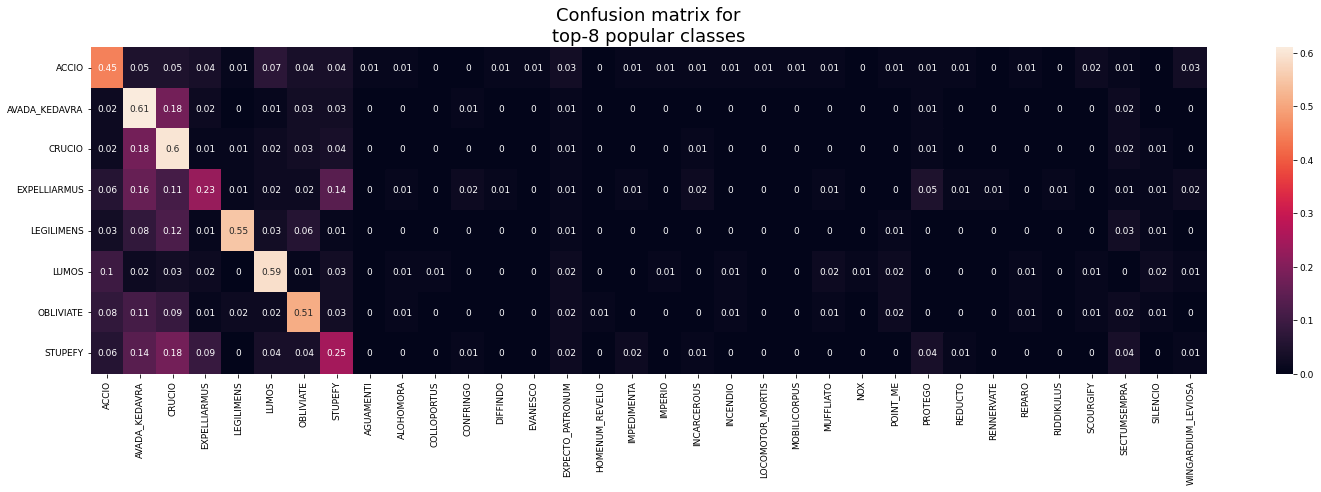

In [ ]:
matrix=confusion_matrix(y_true,y_pred)
matrix = np.round((matrix/(np.tile(matrix.sum(axis=1).reshape(-1,1),matrix.shape[0]))),2)
most_frequent_nums=np.arange(classes_lbs.shape[0])[np.isin(classes_lbs, most_frequent_classes)]
matrix = matrix[most_frequent_nums]
not_null_ids=np.arange(classes_lbs.shape[0])[(matrix.sum(axis=0)>0) & (~(np.isin(classes_lbs, most_frequent_classes)))]
matrix=matrix[:,np.append(most_frequent_nums,not_null_ids)]

plt.figure(figsize=(25,6))
plt.rcParams['font.size'] = 9
ax=sns.heatmap(matrix,annot = True, xticklabels = classes_lbs[np.append(most_frequent_nums,not_null_ids)], yticklabels = classes_lbs[most_frequent_nums])
ax.set_title(f"Confusion matrix for\ntop-{top_classes_num} popular classes",fontsize=18)
plt.show()

Во-первых видим, что диагональ самая яркая, то есть эти классы предсказыватся верно довольно часто. Во-вторых, видим, что модель чаще всего путает популярные классы с популярными (область среза за квадратом 8*8, соответствующая ошибкам модели в сторону менее популярных классов, совсем чёрная).

Аналогично изобразим срез confusion matrix для топ $n$ самых непопулярных классов. Срез выглядит стандартным образом: по вертикали отложены наши топ $n$ классов по порядку, по горизонтали - наши топ $n$ классов и все остальные, с которыми модель их путает. Таким образом, каждая строчка среза показывает качество классификации для $i$-го редкого класса.

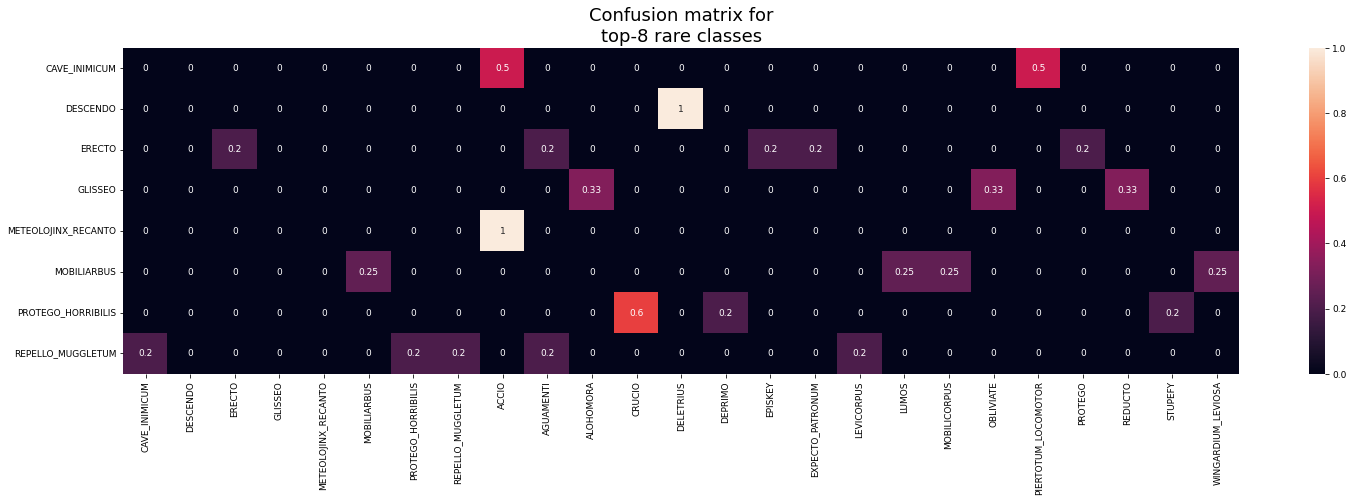

In [ ]:
matrix=confusion_matrix(y_true,y_pred)
matrix = np.round((matrix/(np.tile(matrix.sum(axis=1).reshape(-1,1),matrix.shape[0]))),2)
most_rare_nums=np.arange(classes_lbs.shape[0])[np.isin(classes_lbs, most_rare_classes)]
matrix = matrix[most_rare_nums]
not_null_ids=np.arange(classes_lbs.shape[0])[(matrix.sum(axis=0)>0) & (~(np.isin(classes_lbs, most_rare_classes)))]
matrix=matrix[:,np.append(most_rare_nums,not_null_ids)]

plt.figure(figsize=(25,6))
plt.rcParams['font.size'] = 9
ax=sns.heatmap(matrix,annot = True, xticklabels = classes_lbs[np.append(most_rare_nums,not_null_ids)], yticklabels = classes_lbs[most_rare_nums])
ax.set_title(f"Confusion matrix for\ntop-{top_classes_num} rare classes",fontsize=18)
plt.show()

По срезу видим, что, во-первых, мы вообще довольно редко угадываем. Это не удивительно, так как для этих классов уж совсем мало наблюдений, даже с аугментациями. Кроме того, заметно, что что модель редкие классы в большинстве случаев относит к самым популярным категориям (например, "ACCIO", "CRUCCIO").

Теперь оценим целевую метрику также на самых популярных и самых редких категориях.

In [ ]:
f1_scores = f1_score(y_true,y_pred,average=None)
print(f"F1 macro для самых популярных классов: {np.round(f1_scores[most_frequent_nums].mean(),2)}")
print(f"F1 macro для самых редких классов: {np.round(f1_scores[most_rare_nums].mean(),2)}")

F1 macro для самых популярных классов: 0.43
F1 macro для самых редких классов: 0.13


Таким образом, наша сетка путает самые редкие классы и в большинстве случаев классифицирует их самыми популярными классами. Но есть и другие типы ошибок. Так, имеются ошибки для похожих заклятий:

1. Первай пара похожих заклятий, которые модель путает, была уже видна из предыдущих срезов confusion matrix. Это 2 непростительных заклятья AVADA_KEDAVRA и CRUCIO. Отрисуем для них индивидуально срез confusion matrix:

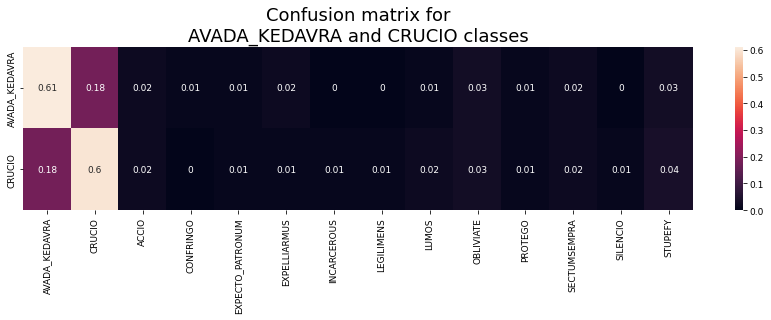

In [ ]:
difficult_classes = np.array(["AVADA_KEDAVRA","CRUCIO"])

matrix=confusion_matrix(y_true,y_pred)
matrix = np.round((matrix/(np.tile(matrix.sum(axis=1).reshape(-1,1),matrix.shape[0]))),2)
difficult_classes_nums=np.arange(classes_lbs.shape[0])[np.isin(classes_lbs, difficult_classes)]
matrix = matrix[difficult_classes_nums]
not_null_ids=np.arange(classes_lbs.shape[0])[(matrix.sum(axis=0)>0) & (~(np.isin(classes_lbs, difficult_classes)))]
matrix=matrix[:,np.append(difficult_classes_nums,not_null_ids)]

plt.figure(figsize=(15,3))
plt.rcParams['font.size'] = 9
ax=sns.heatmap(matrix,annot = True, xticklabels = classes_lbs[np.append(difficult_classes_nums,not_null_ids)], yticklabels = classes_lbs[difficult_classes_nums])
string=" and ".join(difficult_classes)
ax.set_title(f"Confusion matrix for\n{string} classes",fontsize=18)
plt.show()

Оба этих заклинания используются в похожих ситуациях, для убийства, и по графику очевидно, что модель их часто путает.

2. Вторая пара похожих заклинаний - включить и выключить свет. Отрисуем для них индивидуально срез confusion matrix:

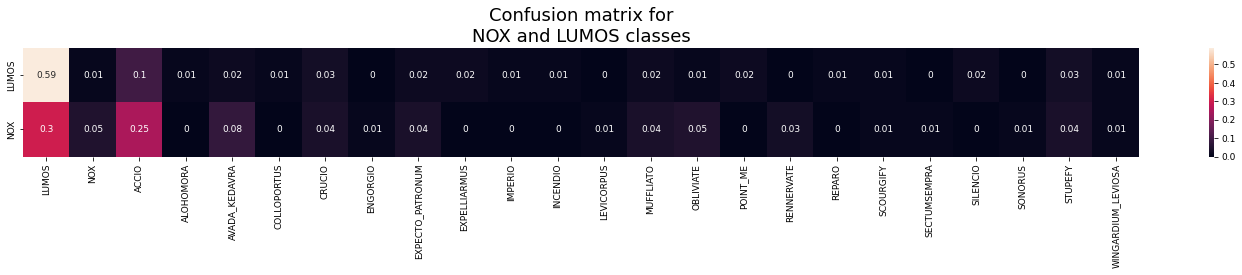

In [ ]:
difficult_classes = np.array(["NOX", "LUMOS"])

matrix=confusion_matrix(y_true,y_pred)
matrix = np.round((matrix/(np.tile(matrix.sum(axis=1).reshape(-1,1),matrix.shape[0]))),2)
difficult_classes_nums=np.arange(classes_lbs.shape[0])[np.isin(classes_lbs, difficult_classes)]
matrix = matrix[difficult_classes_nums]
not_null_ids=np.arange(classes_lbs.shape[0])[(matrix.sum(axis=0)>0) & (~(np.isin(classes_lbs, difficult_classes)))]
matrix=matrix[:,np.append(difficult_classes_nums,not_null_ids)]

plt.figure(figsize=(25,2))
plt.rcParams['font.size'] = 9
ax=sns.heatmap(matrix,annot = True, xticklabels = classes_lbs[np.append(difficult_classes_nums,not_null_ids)], yticklabels = classes_lbs[difficult_classes_nums])
string=" and ".join(difficult_classes)
ax.set_title(f"Confusion matrix for\n{string} classes",fontsize=18)
plt.show()

Следующий раздел посвящён попыткам поднять качество решения задачи. Попробуем трансформеры для решения задачи. Будем использовать предобученный BERT из чекпоинта "distilbert-base-uncased" и дообучим его:

In [ ]:
! pip -q install transformers datasets

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from datasets import load_metric
from transformers import TrainingArguments, Trainer

In [ ]:
MODEL_CHECKPOINT = "distilbert-base-uncased"

In [ ]:
int2class = dict(enumerate(np.sort(train["target"].unique())))
class2int = {word: num for num, word in int2class.items()}

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["text"],truncation=True)

def make_dataset_for_transformer(train):
    train_dataset = Dataset.from_pandas(train[["text","target"]])
    train_dataset = train_dataset.rename_columns({'target':'label', 'text':'text'})
    train_dataset = train_dataset.map(lambda x: {'label':class2int[x['label']],'text':x['text']})
    tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
    return tokenized_dataset

In [ ]:
train_dataset = make_dataset_for_transformer(train)
eval_dataset = make_dataset_for_transformer(val)

  0%|          | 0/60980 [00:00<?, ?ex/s]

  0%|          | 0/61 [00:00<?, ?ba/s]

  0%|          | 0/7605 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(int2class))

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="steps",
    eval_steps = 200,
    per_device_train_batch_size=32,
    seed=42,
    learning_rate=1e-4,
    num_train_epochs=1000
)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 60980
  Num Epochs = 1000
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1906000
  Number of trainable parameters = 67018837
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is f

Step,Training Loss,Validation Loss,F1
200,No log,3.202193,0.016493
400,No log,2.993471,0.045746
600,3.161800,2.832834,0.060546
800,3.161800,2.742110,0.072391
1000,2.771000,2.722234,0.070860
1200,2.771000,2.626440,0.092412
1400,2.771000,2.567467,0.096624
1600,2.635900,2.553935,0.096169
1800,2.635900,2.546977,0.105004
2000,2.502400,2.522154,0.107094


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7605
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7605
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint

Step,Training Loss,Validation Loss,F1
200,No log,3.202193,0.016493
400,No log,2.993471,0.045746
600,3.161800,2.832834,0.060546
800,3.161800,2.742110,0.072391
1000,2.771000,2.722234,0.070860
1200,2.771000,2.626440,0.092412
1400,2.771000,2.567467,0.096624
1600,2.635900,2.553935,0.096169
1800,2.635900,2.546977,0.105004
2000,2.502400,2.522154,0.107094


Saving model checkpoint to test_trainer/checkpoint-7500
Configuration saved in test_trainer/checkpoint-7500/config.json
Model weights saved in test_trainer/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-7500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-7500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7605
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num

KeyboardInterrupt: ignored

Судя по динамике метрики на валидационном датасете, мы начали переобучаться. Вернёмся к лучшему чекпоинту и обернём лучшую модель в пайплайн: 

In [20]:
from transformers import pipeline

best_model=AutoModelForSequenceClassification.from_pretrained("test_trainer//checkpoint-8000").to("cpu")
classification_pipeline = pipeline("text-classification",model=best_model,tokenizer=tokenizer);

loading configuration file test_trainer//checkpoint-8000/config.json
Model config DistilBertConfig {
  "_name_or_path": "test_trainer//checkpoint-8000",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_

Ради забавы проверим адекватность модели на своих примерах, взятых из головы:

In [23]:
example = "voldemort said i will kill you"
prediction = int2class[int(classification_pipeline(example)[0]["label"].strip("LABEL_"))]
print(f"Предсказанный класс: {prediction}")

Предсказанный класс: AVADA_KEDAVRA


In [24]:
example = "it is very dark"
prediction = int2class[int(classification_pipeline(example)[0]["label"].strip("LABEL_"))]
print(f"Предсказанный класс: {prediction}")

Предсказанный класс: LUMOS


In [25]:
example = "dementors are attacking"
prediction = int2class[int(classification_pipeline(example)[0]["label"].strip("LABEL_"))]
print(f"Предсказанный класс: {prediction}")

Предсказанный класс: EXPECTO_PATRONUM


Очень хорошо, учитывая ещё то, что эти результаты не приходилось подбирать, всё получилось с первого раза!

Теперь посчитаем целевую метрику на тестовой выборке:

In [30]:
preds = test["text"].apply(lambda example: int2class[int(classification_pipeline(example)[0]["label"].strip("LABEL_"))])

In [29]:
metrics = f1_score(test["target"],preds,average="macro")
print(f"F1 macro avg. = {metrics}")

F1 macro avg. = 0.17255674207519123


В результате имеем, что трансформер справился с задачей лучше всех, что вполне ожидаемо.

# Часть 4

В ходе работы, во-первых, была протестирована работа одной из самых популярных моделей для построения эмбеддингов слов по текстам fasttext. Результаты говорят о том, что эта модель многое выучила, но их нельзя назвать идеальными. Тексты довольно сложные, и судя по визуальному анализу, часть из них вообще мало связана с книгами о Гарри Поттере. Однако какие-то простые связи модель всё-таки выучила судя по анализу синонимов, ассоциаций. Во-вторых, в работе была протестирована работа рекуррентных нейронных сетей для задачи классификации описаний ситуаций и подходящих под них заклинаний. В данной задаче, судя по сравнению качества построенных моделей и приведённых авторами экспериментов, получилось сделать неплохую модель, опережающую по целевой метрике все модели из статьи. Однако анализ показал, что модель сильно путается на редких в обучающей выборке классах, обычно классифицируя их популярными классами. Поэтому аугментирование примеров редких классов позволило существенно улучшить качество модели. В третьих, задача была решена также с помощью BERT. Ожидаемо данная модель показала самый лучший результат. Более того, тесты на своих игрушечных примерах из головы наталкивают на мысль, что модель очень даже неплохая.